# Лабораторна робота 4

### Завдання: 
    
#### 1.  Завдання щодо генерації текстів або машинного перекладу (на вибір) на базі рекурентних мереж або трансформерів (на вибір). 
Вирішіть завдання щодо генерації текстів або машинного перекладу. Особливо вітаються україномовні моделі.  
Датасети для перекладу можна брати тут: https://www.manythings.org/anki/
Тексти українською для навчання генеративних моделей: https://www.kaggle.com/datasets/mykras/ukrainian-texts

#### 2. Проведіть експерименти з моделями бібліотеки HF Transformers (https://huggingface.co/) за допомогою (наприклад) Pipeline модуля

#### 3. Завдання щодо генерації або стилізації зображень (на вибір)
Вирішіть завдання перенесення стилю або генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE).

### Завдання 1. Машинний переклад на базі RNN

In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential

from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM, Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

In [126]:
text_file = r"C:\Users\Sofi\opencv\Scripts\master_study\Data_analysis\ukr.txt"

data=pd.read_csv(text_file,delimiter='\t',header=None).head(10000)

In [127]:
data.rename(columns={0: "English", 1: "Ukraine"},inplace=True)
data = data.drop(2,axis=1)

In [128]:
from string import ascii_letters, whitespace

def clean_text(text):
    cyrillic_letters = u"абвгдежзиійклмнопрстуфхцчшщьєюяАБВГДЕЖЗИІЙКЛМНОПРСТУФХЦЧШЩЬЄЮЯ"
    allowed_chars = cyrillic_letters + ascii_letters + whitespace
    r = "".join([c for c in text if c in allowed_chars])
    r = r.lower()
    return r

data["English"] = data["English"].apply(clean_text)
data["Ukraine"] = data["Ukraine"].apply(clean_text)

In [133]:
data = data.drop_duplicates(subset='English')

In [138]:
data[4000:4100]

,English,Ukraine
7156,god bless you,нехай господь тебе благославить
7157,good riddance,нехай щастить
7158,grab the rope,хапай мотузку
7160,have a cookie,візьми печиво
7163,have some fun,розважся
...,...,...
7312,i can survive,я можу вижити
7313,i cant dance,я не вмію танцювати
7315,i cant do it,я не можу це зробити
7317,i cant go on,я не можу продовжувати


In [135]:
def tokenize(x):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

In [136]:
def pad(x, length=None):
    return pad_sequences(x, maxlen=length, padding='post')

In [137]:
def preprocess(x, y):
    
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_ukr_sentences, english_tokenizer, ukr_tokenizer = preprocess(data['English'].values, data['Ukraine'].values)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_ukr_sequence_length = preproc_ukr_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
ukr_vocab_size = len(ukr_tokenizer.word_index)

print("Max English sentence length:", max_english_sequence_length)
print("Max Ukraine sentence length:", max_ukr_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("Ukraine vocabulary size:", ukr_vocab_size)

Max English sentence length: 4
Max Ukraine sentence length: 7
English vocabulary size: 1920
Ukraine vocabulary size: 3355


In [139]:
def model_final(input_shape, output_sequence_length, english_vocab_size, ukr_vocab_size):
    
   # learning_rate = 0.003
    
    model = Sequential()

    model.add(Embedding(english_vocab_size, 128, input_length=input_shape[1],
                         input_shape=input_shape[1:]))
    # Encoder
    model.add(Bidirectional(LSTM(128)))
    model.add(RepeatVector(output_sequence_length))
    
    # Decoder
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(TimeDistributed(Dense(512, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(ukr_vocab_size, activation='softmax')))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(),
                  metrics=['accuracy'])
    return model

In [191]:
model = model_final(preproc_english_sentences.shape,preproc_ukr_sentences.shape[1],
                        len(english_tokenizer.word_index)+1,
                        len(ukr_tokenizer.word_index)+1)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 4, 128)            245888    
                                                                 
 bidirectional_12 (Bidirect  (None, 256)               263168    
 ional)                                                          
                                                                 
 repeat_vector_6 (RepeatVec  (None, 7, 256)            0         
 tor)                                                            
                                                                 
 bidirectional_13 (Bidirect  (None, 7, 256)            394240    
 ional)                                                          
                                                                 
 time_distributed_12 (TimeD  (None, 7, 512)            131584    
 istributed)                                          

In [192]:
model.fit(preproc_english_sentences, preproc_ukr_sentences, batch_size=64, epochs=100, validation_split=0.2)

Epoch 1/100
71/71 [==============================] - 11s 95ms/step - loss: 3.6371 - accuracy: 0.6549 - val_loss: 2.6797 - val_accuracy: 0.6287
Epoch 2/100
71/71 [==============================] - 6s 82ms/step - loss: 2.3024 - accuracy: 0.6858 - val_loss: 2.6071 - val_accuracy: 0.6290
Epoch 3/100
71/71 [==============================] - 6s 83ms/step - loss: 2.1866 - accuracy: 0.6870 - val_loss: 2.5965 - val_accuracy: 0.6303
Epoch 4/100
71/71 [==============================] - 6s 82ms/step - loss: 2.1292 - accuracy: 0.6880 - val_loss: 2.6069 - val_accuracy: 0.6306
Epoch 5/100
71/71 [==============================] - 6s 80ms/step - loss: 2.0873 - accuracy: 0.6887 - val_loss: 2.6095 - val_accuracy: 0.6366
Epoch 6/100
71/71 [==============================] - 6s 79ms/step - loss: 2.0349 - accuracy: 0.6974 - val_loss: 2.6018 - val_accuracy: 0.6552
Epoch 7/100
71/71 [==============================] - 6s 80ms/step - loss: 1.9733 - accuracy: 0.7054 - val_loss: 2.5776 - val_accuracy: 0.6709
Epoch

In [212]:
x, y, x_tk, y_tk = preproc_english_sentences, preproc_ukr_sentences, english_tokenizer, ukr_tokenizer
    
y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
y_id_to_word[0] = '<PAD>'

sentences = ['i can do it','you are happy','i want to have money']
for sentence in sentences:
    sentence = [x_tk.word_index[word] for word in sentence.split()]
    sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
    predictions = model.predict(sentence)
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))


1/1 [==============================] - 0s 20ms/step
я можу це зробити <PAD> <PAD> <PAD>
1/1 [==============================] - 0s 20ms/step
ти задоволена <PAD> <PAD> <PAD> <PAD> <PAD>
1/1 [==============================] - 0s 20ms/step
мені потрібно гроші <PAD> <PAD> <PAD> <PAD>


In [208]:
sentences[0] in list(data['English'])

True

In [207]:
sentences[1] in list(data['English'])

False

In [213]:
sentences[2] in list(data['English'])

False

### Завдання 2

In [3]:
from transformers import pipeline

classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [9]:
txt_1 = 'Football is the most exciting and popular game in the world'
print(f'{txt_1}: {classifier(txt_1)}')

txt_2 = 'The weather is unpredictable around here'
print(f'{txt_2}: {classifier(txt_2)}')

Football is the most exciting and popular game in the world: [{'label': 'POSITIVE', 'score': 0.9998573064804077}]
The weather is unpredictable around here: [{'label': 'POSITIVE', 'score': 0.6950810551643372}]


In [12]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
model_name = "robinhad/ukrainian-qa"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

qa_model = pipeline("question-answering", model=model.to("cpu"), tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/469 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/854k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

{'score': 0.37632718682289124, 'start': 43, 'end': 50, 'answer': ' Криму,'}

In [46]:
question = "Що таке Молочний шлях?"
context = "Ще в давнину люди бачили на нічному небі скупчення зірок, яке нагадувало їм розлите молоко. Молочний шлях - офіційна назва нашої галактики. В Україні ж зірки на небі, які утворюю славнозвісну світлу смугу, були для чумаків, що везли з Криму сіль, орієнтиром для пошуку правильної дороги вночі і нагадували їм розсипану сіль. Тому в Україні існує альтернативна назва галактики - Чумацький шлях"
qa_model(question = question, context = context)

{'score': 0.42942148447036743,
 'start': 107,
 'end': 139,
 'answer': ' офіційна назва нашої галактики.'}

In [48]:
question = "Що таке Чумацький шлях?"
context = "Ще в давнину люди бачили на нічному небі скупчення зірок, яке нагадувало їм розлите молоко. Молочний шлях - офіційна назва нашої галактики. В Україні ж зірки на небі, які утворюю славнозвісну світлу смугу, були орієнтиром для пошуку правильної дороги вночі для чумаків, що везли з Криму сіль. Тому в Україні існує альтернативна назва галактики - Чумацький шлях"
qa_model(question = question, context = context)

{'score': 0.04299766942858696,
 'start': 313,
 'end': 343,
 'answer': ' альтернативна назва галактики'}

### Завдання 3. Генерація зображень

In [214]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import cv2 as cv

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image


In [308]:
import os

path='C:\\Users\\Sofi\\opencv\\Scripts\\master_study\\Data_analysis\\' 
classes= pd.read_csv(path+"\\Training_set.csv")
images = []
for filename in classes.filename:
    img = image.load_img(path+"train\\"+filename, target_size=(64, 64))
    images.append(image.img_to_array(img))
images = np.array(images)

In [309]:
classes.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


C:\Users\Sofi\AppData\Local\Temp\ipykernel_14668\4073137086.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.random.randint(0,images.shape[0],1))


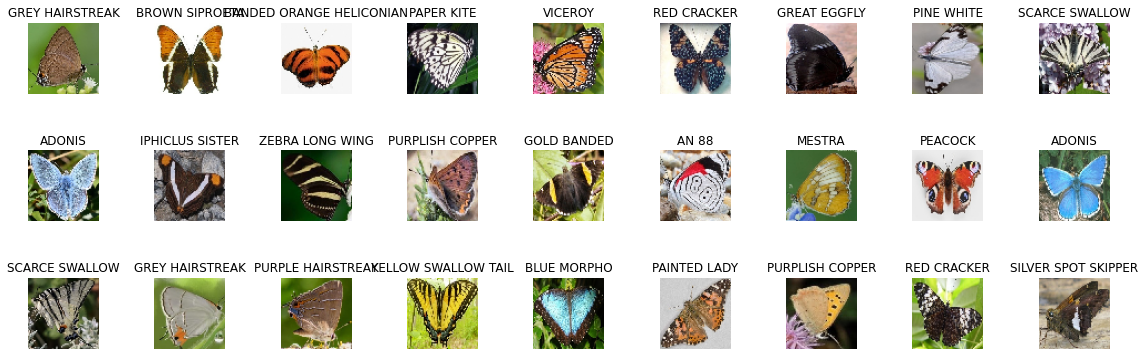

In [313]:
plt.figure(figsize=(20, 6))
plt.rcParams['font.size'] = 10
for i in range(27):
    plt.subplot(3,9,i+1)
    plt.axis('off')
    j = int(np.random.randint(0,images.shape[0],1))
    plt.imshow(images[j]/255)
    plt.title(classes.label[j])
    plt.subplots_adjust(hspace=.8)

In [552]:
classes.label.value_counts()[:10]

MOURNING CLOAK              131
SLEEPY ORANGE               107
ATALA                       100
BROWN SIPROETA               99
CRECENT                      97
SCARCE SWALLOW               97
BANDED ORANGE HELICONIAN     97
MILBERTS TORTOISESHELL       96
RED CRACKER                  96
ORANGE TIP                   96
Name: label, dtype: int64

In [571]:
X_train = [images[i] for i in np.where(classes.label=='PEACOCK')][0]

In [572]:
X_train.shape

(84, 64, 64, 3)

In [573]:
input_dim = 64*64*3
X_train = X_train.reshape(X_train.shape[0], input_dim)
print('input shape: ', X_train.shape[1])
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # normilization [-1, 1]

input shape:  12288


In [574]:
from tensorflow.keras.optimizers.legacy import Adam

optim = keras.optimizers.legacy.Adam(learning_rate=0.001)

In [575]:
def build_discriminator():
    model =  keras.Sequential()
    model.add(layers.Dense(512*1, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.1))
        
    model.add(layers.Dense(256*1))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(128*1))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
        
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [576]:
latent_dim = 100

def build_generator():
    model =  keras.Sequential()
    model.add(layers.Dense(128*2, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.01)))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(256*2))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(512*2))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(input_dim, activation='tanh'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model  

In [577]:
discriminator = build_discriminator()
generator = build_generator()

# Combined network
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = keras.Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optim)

In [578]:
def plot_generated_images(epoch, generator):
    num_of_images = 5
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise,verbose=0).reshape(num_of_images, 64,64,3)
    plt.figure()
    for i in range(num_of_images):
        plt.subplot(1, 5, i+1)
        plt.imshow((generated_images[i]/2+0.5))
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [579]:
discrim_losses = []
generator_losses = []

def train_model(epochs, batch_size):
    d_loss = 0
    gan_loss=0
    num_batches = int(X_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            
             # Generate fake MNIST images
            generated_images = generator.predict(noise,verbose=0)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9  # (instead of 1.0) sort of trick in GAN training, so called label smoothing
            # Train discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan_loss = gan.train_on_batch(noise, y_gen)
            generator_losses.append(gan_loss)

        if ep % 10 == 0:
            print('epoch: ', ep)
            print(ep, "discriminator loss: ", d_loss,"generator loss: ", gan_loss)
            plot_generated_images(ep, generator)

epoch:  0
0 discriminator loss:  1.3229765892028809 generator loss:  0.20323839783668518


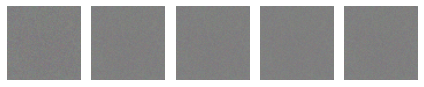

epoch:  10
10 discriminator loss:  0.7334514856338501 generator loss:  1.824521780014038


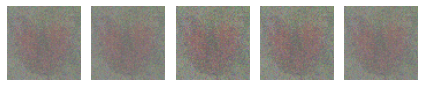

epoch:  20
20 discriminator loss:  0.5371031761169434 generator loss:  0.8305296897888184


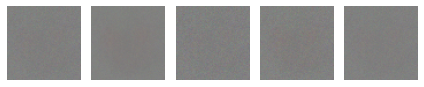

epoch:  30
30 discriminator loss:  0.8116893768310547 generator loss:  1.2471998929977417


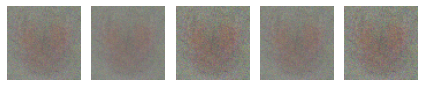

epoch:  40
40 discriminator loss:  0.5791802406311035 generator loss:  2.7861804962158203


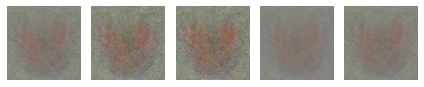

epoch:  50
50 discriminator loss:  0.6849603652954102 generator loss:  1.2351949214935303


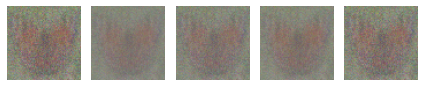

epoch:  60
60 discriminator loss:  0.6917579770088196 generator loss:  0.927181601524353


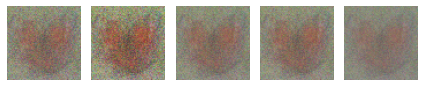

epoch:  70
70 discriminator loss:  0.4823300838470459 generator loss:  3.3638463020324707


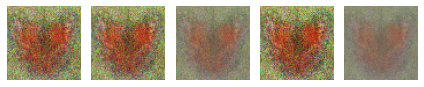

epoch:  80
80 discriminator loss:  0.5436683893203735 generator loss:  2.189265251159668


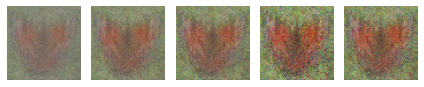

epoch:  90
90 discriminator loss:  0.45018815994262695 generator loss:  3.449293613433838


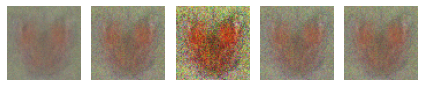

epoch:  100
100 discriminator loss:  0.32987159490585327 generator loss:  2.8423080444335938


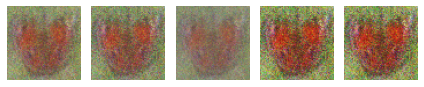

In [541]:
epochs = 100
batch_size = 16
train_model(epochs, batch_size)